# 06. 因果推論：合成對照組 (Synthetic Control Method, SCM)

**目的**：由於缺乏外部國家數據，我們將採用 **Regional SCM (區域合成對照法)**。
**概念**：
*   **Treatment Unit**：雙北地區 (台北市/新北市) - 疫情最嚴重的「處理組」。
*   **Donor Pool**：其他縣市 (高雄、台中、花蓮等) - 疫情相對受控的「對照組」。
*   **假設**：如果雙北沒有發生「諾富特/萬華」破口，其疫情發展應可由其他縣市的加權組合來擬合。
**分析步驟**：
1.  資料聚合：將鄉鎮市區資料聚合為「縣市」層級。
2.  定義區間：
    *   **Pre-intervention**: 2021-01-01 ~ 2021-04-30 (疫情爆發前)
    *   **Post-intervention**: 2021-05-01 ~ 2021-08-31 (疫情爆發期)
3.  權重優化 (Optimization)：尋找最佳權重 $W$，使得 $Y_{Taipei} \approx \sum W_i * Y_{Others}$ 在爆發前成立。
4.  反事實預測：使用相同 $W$ 推估爆發後的「合成雙北」，計算 Gap (Excess cases)。

Loading Data...
Data loaded. Shape: (1446, 369)
Cities/Counties: ['南投縣', '台中市', '台北市', '台南市', '台東縣', '嘉義市', '嘉義縣', '基隆市', '宜蘭縣', '屏東縣', '彰化縣', '新北市', '新竹市', '新竹縣', '桃園市', '澎湖縣', '花蓮縣', '苗栗縣', '連江縣', '金門縣', '雲林縣', '高雄市']
Target: 台北市
Donor Pool (18): ['南投縣', '台中市', '台南市', '台東縣', '嘉義市', '嘉義縣', '宜蘭縣', '屏東縣', '彰化縣', '新竹市', '新竹縣', '澎湖縣', '花蓮縣', '苗栗縣', '連江縣', '金門縣', '雲林縣', '高雄市']
Starting Optimization...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 30432.061217013394
            Iterations: 4
            Function evaluations: 68
            Gradient evaluations: 3
Optimization Success: True
Optimization Message: Optimization terminated successfully
Optimal Weights:
  彰化縣: 1.000
Generating Plots...
Displaying plot 1...


C:\Users\flash\AppData\Local\Temp\ipykernel_171252\2320441248.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_city = df.groupby(cities, axis=1).sum()


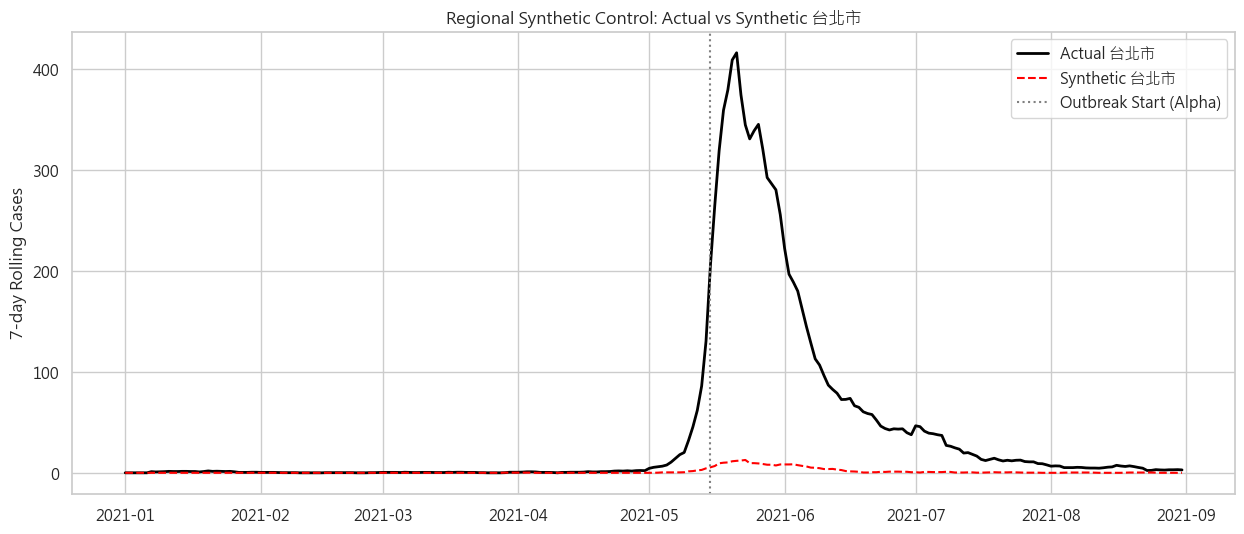

Displaying plot 2...


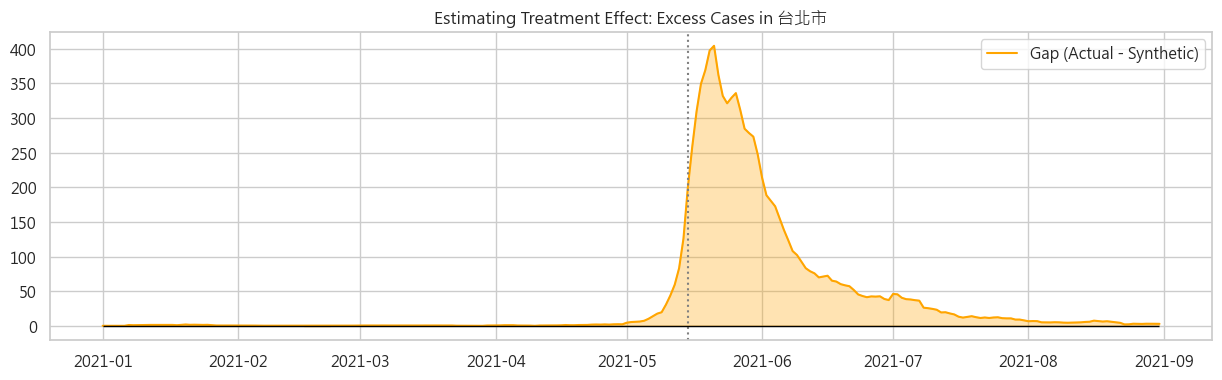

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import os
import sys

sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 1. 資料載入與聚合
processed_data_dir = "../data/processed"
file_case = os.path.join(processed_data_dir, "twcdc_daily_cases_by_location.csv")

print("Loading Data...", flush=True)
try:
    df = pd.read_csv(file_case, index_col='Date', parse_dates=True)
    print(f"Data loaded. Shape: {df.shape}", flush=True)
    
    # 原始 columns 是 "縣市_鄉鎮" (e.g., "南投縣_中寮鄉")
    # 我們需要 aggregate 到 "縣市" (e.g., "南投縣")
    
    # Extract City/County name (first 3 chars usually, or split by '_')
    cities = [c.split('_')[0] for c in df.columns]
    df_city = df.groupby(cities, axis=1).sum()
    
    print(f"Cities/Counties: {df_city.columns.tolist()}", flush=True)
    
    # 2. 設定 Treatment Unit 與 Donor Pool
    # 新北市與台北市是重災區，我們合成「台北市」作為範例
    target_city = '台北市'
    
    # 排除雙北與鄰近可能溢出的縣市 (如基隆、桃園)，選擇相對獨立的南部/東部縣市作為 Donor
    # 這裡簡單排除 '新北市', '基隆市', '桃園市' 
    exclude_cities = [target_city, '新北市', '基隆市', '桃園市']
    donor_pool = [c for c in df_city.columns if c not in exclude_cities]
    
    print(f"Target: {target_city}", flush=True)
    print(f"Donor Pool ({len(donor_pool)}): {donor_pool}", flush=True)
    
    # 2021年 Alpha 波段
    # Pre-period: 2021年初到4月底 (其實在此之前案例都很少，可能雜訊多，但試試看)
    # 或許我們應該包含 2020 年？但 2020 幾乎 +0，無法擬合。
    # 這是 COVID SCM 的難點：Pre-period 幾乎都是 0，權重會很隨機。
    # 解決方案：包含一些微小的波動期，或者使用「移動平均」來平滑。
    
    start_date = '2021-01-01'
    intervention_date = '2021-05-15'
    end_date = '2021-08-31'
    
    data_scm = df_city.loc[start_date:end_date].copy()
    
    # 7-day rolling average to smooth out daily noise (especially zeros)
    data_scm_smooth = data_scm.rolling(7).mean().fillna(0)
    
    y_target = data_scm_smooth[target_city]
    X_donors = data_scm_smooth[donor_pool]
    
    # Split Pre/Post
    is_pre = data_scm.index < intervention_date
    y_pre = y_target[is_pre]
    X_pre = X_donors[is_pre]
    
    X_post = X_donors[~is_pre]
    y_post = y_target[~is_pre]
    
    # 3. 權重優化 (Optimization)
    # Loss = || Y_target - X_donor * W ||^2
    # Constraints: sum(W) = 1, W >= 0
    
    print("Starting Optimization...", flush=True)
    
    def loss_func(W, X, y):
        # X: (T, N), W: (N,)
        error = y - X @ W
        return np.sum(error**2)
    
    n_donors = X_pre.shape[1]
    W0 = np.ones(n_donors) / n_donors
    bounds = [(0, 1) for _ in range(n_donors)]
    constraints = {'type': 'eq', 'fun': lambda W: np.sum(W) - 1}
    
    # 使用 SLSQP，增加顯示選項以便除錯
    res = minimize(loss_func, W0, args=(X_pre, y_pre), 
                   bounds=bounds, constraints=constraints, method='SLSQP', 
                   options={'disp': True, 'maxiter': 1000, 'ftol': 1e-6})
    
    print(f"Optimization Success: {res.success}", flush=True)
    print(f"Optimization Message: {res.message}", flush=True)
    
    weights = res.x
    print("Optimal Weights:", flush=True)
    for city, w in zip(donor_pool, weights):
        if w > 0.01: # Show significant weights
            print(f"  {city}: {w:.3f}", flush=True)
            
    # 4. 合成與視覺化
    print("Generating Plots...", flush=True)
    synthetic_target = X_donors @ weights
    
    plt.figure(figsize=(15, 6))
    plt.plot(y_target.index, y_target, label=f'Actual {target_city}', color='black', linewidth=2)
    plt.plot(synthetic_target.index, synthetic_target, label=f'Synthetic {target_city}', color='red', linestyle='--')
    
    plt.axvline(pd.to_datetime(intervention_date), color='grey', linestyle=':', label='Outbreak Start (Alpha)')
    
    plt.title(f'Regional Synthetic Control: Actual vs Synthetic {target_city}')
    plt.ylabel('7-day Rolling Cases')
    plt.legend()
    print("Displaying plot 1...", flush=True)
    plt.show()
    
    # 5. Gap Analysis (Excess Cases)
    gap = y_target - synthetic_target
    
    plt.figure(figsize=(15, 4))
    plt.plot(gap.index, gap, color='orange', label='Gap (Actual - Synthetic)')
    plt.axvline(pd.to_datetime(intervention_date), color='grey', linestyle=':')
    plt.hlines(0, gap.index.min(), gap.index.max(), color='black', linewidth=1)
    plt.title(f'Estimating Treatment Effect: Excess Cases in {target_city}')
    plt.fill_between(gap.index, gap, 0, where=(gap>0), color='orange', alpha=0.3)
    plt.legend()
    print("Displaying plot 2...", flush=True)
    plt.show()
    
except Exception as e:
    print(f"Error: {e}", flush=True)